In [1]:
%matplotlib inline

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as si

In [3]:
import adolc

In [4]:
# from clawpack.geoclaw import dtopotools
adapt_utils_home = os.environ.get('ADAPT_UTILS_HOME')
sys.path.append(os.path.join(adapt_utils_home, 'unsteady', 'swe', 'tsunami'))
import dtopotools

# Automatic differentation of the Okada functions

### Okada functions

As in the `okada.ipynb` notebook, we generate a source comprised of an array of Okada functions, using the work of [Shao et al. 2012].

A $19\times10$ array of subfaults is used, each of which is assumed to be based on a rectangular patch with length $25\,\mathrm{km}$ and width $20\,\mathrm{km}$.
For the Okada function associated with each of the $190$ subfaults, there are nine control parameters:

  1. latitude;
  2. longitude;
  3. depth;
  4. slip;
  5. rake;
  6. strike;
  7. dip;
  8. length;
  9. width.

Each Okada function returns an $N\times N$ array of values, where $N$ is to be specified by the user and can be thought of as grid resolution for the topography field.
The contribution of each is summed in order to generate the total topography.

In summary, `okada` can be thought of as a function with $190\times9=1710$ scalar inputs and $N^2$ scalar outputs.

### The AD tool

In this notebook, we apply the Python wrapper `pyadolc` to the C++ operator overloading automatic differentiation tool `ADOL-C`.
`ADOL-C` works by overloading common functions with known derivatives using C++ templates.
An enriched version of the `double` type is provided: the `adouble`.
The main difference is that `adouble`s are able to propagate derivatives as well as their 'standard' values.
Operations on `adouble`s are recorded on a tape so that the workflow can be read at a later time and both forward and reverse mode derivatives may be automatically generated.

From experience, I can say that applying `ADOL-C` to an existing C or C++ code is not always completely straightforward (at least for the non-expert user), since extra memory needs to be allocated for `adouble`s due to their enriched storage.
In Python, memory handling is not typically something the user needs to worry about and so the process becomes somewhat simpler.

Suppose we have a function $f=f(x)$ and its Python implementation `f`.
If the piece of code we would like to differentiate looks like

    y = f(x)
    
then the `pyadolc` differentiated version looks like

    adolc.trace_on(tag)
    x_a = adolc.adouble(x)
    adolc.independent(x_a)
    y_a = f(x_a)
    adolc.dependent(y_a)
    adolc.trace_off()

where `tag` is simply a label for the tape being used.
Evaluating (for example) the gradient of $f$ at a point $x_0$ then becomes as simple as calling the appropriate driver:

    dfdx = adolc.gradient(tag, x0)
    
where $x0$ encodes the point $x_0$.
`pyadolc` supports `numpy` expressions such as `sin`, `cos`, `exp`.

In [5]:
# Get data (assuming that the Okada parameters have already been downloaded)
di = os.path.join(adapt_utils_home, 'case_studies', 'tohoku', 'resources', 'surf')
with open(os.path.join(di, 'okada_parameters.txt')) as f:
    data_str = f.read()

# Set up a dictionary of lists
all_controls = ('latitude', 'longitude', 'depth', 'slip', 'rake', 'strike', 'dip')
source_parameters = {}
for control in all_controls:
    source_parameters[control] = []
source_parameters['length'] = []
source_parameters['width'] = []

# Populate the dictionary
for i, line in enumerate(data_str.split('\n')):
    if i < 12:
        continue
    for word, control in zip(line.split(), all_controls):
        val = float(word)
        if control == 'slip':
            val /= 100  # convert from cm to m
        if control == 'depth':
            val *= 1000  # convert from km to m
        source_parameters[control].append(val)
    if line not in ('', '\n'):
        source_parameters['length'].append(25.0e+03)
        source_parameters['width'].append(20.0e+03)
all_controls += ('length', 'width', )

Create a uniform grid upon which to evaluate Okada function

In [6]:
N = 101
x = np.linspace(138, 148, N)
y = np.linspace(32, 42, N)

When it comes down to it, we realise that we only really want to tune four of the nine parameters: slip, rake, strike and dip.
This means that there are $190\times 4=760$ active input parameters, rather than $1710$.

In [7]:
active_controls = ('slip', 'rake', 'strike', 'dip', )
n = len(active_controls)

We begin by creating a fault based on an array of subfaults built from Okada control parameters GeoCLAW's `Fault` and `Subfault` classes.
The active inputs are `adouble`s which are marked as independent.
The output is a topography field which is marked as dependent.

In [8]:
num_subfaults = len(source_parameters['latitude'])
for var in source_parameters:
    assert len(source_parameters[var]) == num_subfaults

# Create subfaults and fault
subfaults = [dtopotools.SubFault() for i in range(num_subfaults)]
for subfault in subfaults:
    subfault.coordinate_specification = 'centroid'
fault = dtopotools.Fault(x, y, subfaults=subfaults)

tag = 0
adolc.trace_on(tag)  # >>>>> trace on >>>>>

l = 5
msg = "subfault {:3d}: shear modulus {:.4e} Pa, seismic moment is {:.4e}"
for i in range(num_subfaults):
    
    # Read parameters and mark active variables as independent
    for control in all_controls:
        if control in active_controls:
            subfaults[i].__setattr__(control, adolc.adouble(source_parameters[control][i]))
            adolc.independent(subfaults[i].__getattribute__(control))
        else:
            subfaults[i].__setattr__(control, source_parameters[control][i])
        
    # Printing
    if i < l or i > num_subfaults - l - 1:
        print(msg.format(i, subfaults[i].mu, subfaults[i].Mo().val))
    elif i == l:
        print("...")
print("this corresponds to an earthquake with moment magnitude {:.1f}".format(fault.Mw().val))

# Create the topography, thereby calling Okada
print("\nCreating topography...")
fault.create_dtopography()
print("Done!")

# Mark output as dependent
adolc.dependent(fault.dtopo.dZ_a)

adolc.trace_off()  # <<<<< trace off <<<<<

subfault   0: shear modulus 4.0000e+10 Pa, seismic moment is 2.0897e+17
subfault   1: shear modulus 4.0000e+10 Pa, seismic moment is 6.3714e+19
subfault   2: shear modulus 4.0000e+10 Pa, seismic moment is 1.1783e+20
subfault   3: shear modulus 4.0000e+10 Pa, seismic moment is 2.5073e+20
subfault   4: shear modulus 4.0000e+10 Pa, seismic moment is 3.9883e+20
...
subfault 185: shear modulus 4.0000e+10 Pa, seismic moment is 5.8755e+19
subfault 186: shear modulus 4.0000e+10 Pa, seismic moment is 5.4531e+19
subfault 187: shear modulus 4.0000e+10 Pa, seismic moment is 5.9979e+19
subfault 188: shear modulus 4.0000e+10 Pa, seismic moment is 4.9508e+19
subfault 189: shear modulus 4.0000e+10 Pa, seismic moment is 4.9258e+19
this corresponds to an earthquake with moment magnitude 9.1

Creating topography...
created topography for subfault 1/190 (10.0 seconds)
created topography for subfault 11/190 (100.7 seconds)
created topography for subfault 21/190 (105.1 seconds)
created topography for subfau

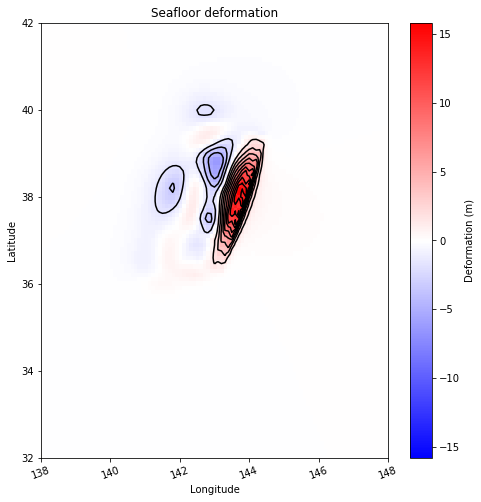

In [9]:
fig, axes = plt.subplots(figsize=(8, 8))
fault.dtopo.plot_dZ_colors(t=1.0, axes=axes);
axes.set_xlabel('Longitude');
axes.set_ylabel('Latitude');

Now consider the parameters as `double`s, rather than `adouble`s.

In [20]:
X = np.array([source_parameters[control][i] for control in active_controls for i in range(num_subfaults)])

The Okada function on each subfault depends only on the control parameters associated with that subfault.
Therefore, the derivatives of the topography with respect to each control parameter of a particular type (e.g. slip) can be computed simultaneously.
In order to do this, we create seed matrices as follows.

In [23]:
seeds = np.array([[1 if i % n == j else 0 for j in range(n)] for i in range(len(X))])

In [25]:
F, dFdX = adolc.fov_forward(tag, X, seeds)
print(F.shape)
print(dFdX.shape)

(10201,)
(10201, 4)


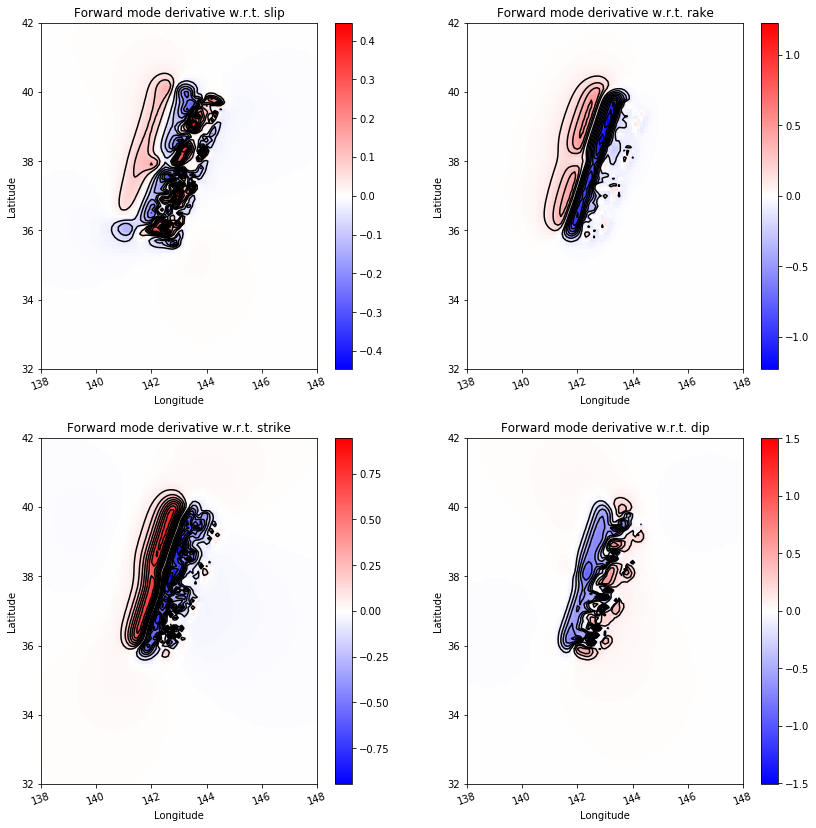

In [26]:
m = int(np.sqrt(n))
fig, axes = plt.subplots(ncols=m, nrows=m, figsize=(7*m, 7*m))

for i, control in enumerate(active_controls):
    ax = axes[i // m, i % m]
    fault.dtopo.dZ = dFdX[:, i].reshape(1, N, N)
    fault.dtopo.plot_dZ_colors(t=1.0, axes=ax);
    ax.set_xlabel('Longitude');
    ax.set_ylabel('Latitude');
    ax.set_title('Forward mode derivative w.r.t. {:s}'.format(control));
    ax.images[-1].colorbar.set_label('');

### Why do we want to differentiate Okada anyway?

The modelling of earthquake-tsunami propagation requires an initial condition for the free surface elevation,

$$
    \eta(x,0)=\eta_0.
$$

It is common in the literature to assume that, under a depth-averaged model such as the shallow water equations, the displacement to the seafloor caused by the earthquake causes an identical displacement to the ocean surface.
Under such an assumption, the Okada model for the dislocation due to an earthquake also provides $\eta_0$.
In the calculations above, we are able to compute the gradient

$$\frac{\mathrm d\eta_0}{\mathrm dm}.$$

_Tsunami_ source inversion involves computing the derivative of some quantity of interest $J$ with respect to the source control parameters:

$$
    \frac{\mathrm dJ}{\mathrm dm},
    \qquad\text{or, more precisely, its action}\qquad
    \frac{\mathrm dJ}{\mathrm dm}\:\tilde m
$$

on a particular control parameter vector $\tilde m$.

In previous notebooks we established that the gradient with respect to the _initial surface_ is given by

$$
    \left(\frac{\mathrm dJ}{\mathrm d\eta_0}\right)_k
    =\int_\Omega\eta^*|_{t=0}\left(\frac{\mathrm d\eta_0}{\mathrm dm}\right)_k\;\mathrm dx,
$$

where $\eta^*$ is the solution of the continuity component of the adjoint equations associated with the tsunami propagation.
By the chain rule we have

$$\frac{\mathrm dJ}{\mathrm dm}=\frac{\mathrm dJ}{\mathrm d\eta_0}\frac{\mathrm d\eta_0}{\mathrm dm}.$$

The first term we can get by solving the adjoint shallow water equations; taken together we have the gradient of the QoI w.r.t. the Okada source parameters.

_[A technical detail is that really we should also differentiate through the interpolation operator which goes from the Okada grid to the computational mesh. Assuming the interpolation is linear, this is trivial.]_